In [1]:
# Import packages and settings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px

import os, sys
dir1 = os.path.dirname(os.path.abspath(''))
if not dir1 in sys.path: sys.path.append(dir1)
import preprocessing.data_format as data_format
import preprocessing.data_cleaning as data_cleaning
import preprocessing.data_imputation as data_imputation
import plotly.graph_objects as go
from IPython.display import display
pd.options.mode.chained_assignment = None
plt.rcParams["figure.figsize"] = (15,5)

In [2]:
dt_resolution = dt.timedelta(minutes=60)
dt_start = dt.datetime(day=1, month=1, year=2000)
dt_end = dt.datetime(day=31, month=7, year=2019) #exclusive last day
dt_ref = pd.date_range(start=dt_start, end=dt_end, freq=str(dt_resolution.seconds) + "S", inclusive="left")

site_id = "NewEngland"
base_url = 'https://github.com/takao8/MLTSAProject/blob/master/data'
timestamp_format = "%Y-%m-%d %H:%M:%S"

data = {}
data['Load'] = pd.read_excel(f'{base_url}/PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx?raw=true', usecols=['Date', 'Nepool_Load_Hist'])
data['Temperature'] = pd.read_csv(f'../data/{site_id}/boston_weather_cleaned.csv', usecols=['DATE', 'HourlyDryBulbTemperature'])

In [3]:
for key, col in zip(data.keys(), ["Date", "DATE"]):
    # Round imprecisions
    data[key][col] = pd.to_datetime(data[key][col], format=timestamp_format).round("S")
    
    # Drop duplicates
    data[key] = data[key].drop_duplicates(subset=col, keep='last')
    
    # Fill missing data
    missing_datetimes = data_format.find_missing_datetime(data[key][col], timestamp_format, dt_resolution, dt_start, dt_end)
    print(f"{key} missing data: {round(100*len(missing_datetimes)/(len(data[key])+len(missing_datetimes)),3)}%")
    if not missing_datetimes.empty:
        data[key] = data_format.fill_missing_datetime(data[key], missing_datetimes, col)
        data[key] = data_format.set_datetimeindex(data[key], dt_resolution, col, timestamp_format)

Load missing data: 0.047%
Temperature missing data: 0.035%


array([<AxesSubplot: xlabel='datetime_index'>,
       <AxesSubplot: xlabel='datetime_index'>], dtype=object)

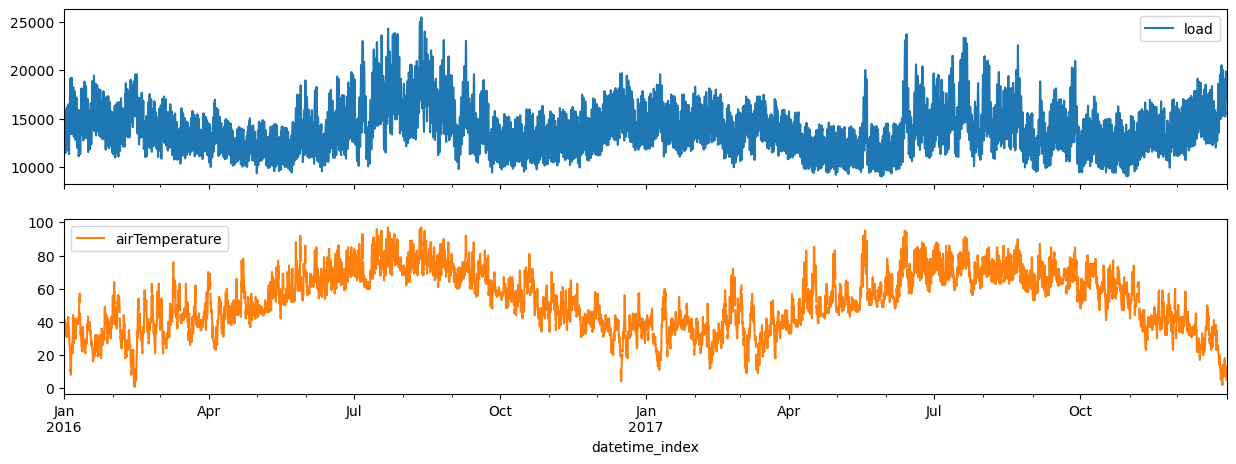

In [4]:
start_bound = "2016-01-01 00:00:00"
end_bound = "2017-12-31 23:00:00"
data = pd.concat(list(data.values()), axis=1).loc[start_bound:end_bound]
data = data.rename(columns={"Nepool_Load_Hist": "load", "HourlyDryBulbTemperature": "airTemperature"})
data.plot(subplots=True)

In [5]:
data

,load,airTemperature
datetime_index,,
2016-01-01 00:00:00,12737.23,NaN
2016-01-01 01:00:00,12502.82,39.0
2016-01-01 02:00:00,12241.11,39.0
2016-01-01 03:00:00,11824.24,38.0
2016-01-01 04:00:00,11616.23,37.0
...,...,...
2017-12-31 19:00:00,19560.71,9.0
2017-12-31 20:00:00,18931.87,8.0
2017-12-31 21:00:00,18309.75,7.0


In [6]:
save_flag = True
data_interpol = data_imputation.interpolate(data)
nans = data_interpol.isna().sum().sum()
if nans==0 and save_flag:
    data_interpol.to_pickle(f"../data/{site_id}/load_with_weather.pkl")
    print("Saved!")

Saved!
